# Load Libraries

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F
import random, math, time
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torchtext.disable_torchtext_deprecation_warning()

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Task 1. Get Language Pair - Based on MT + Transformer.ipynb**

Modify the dataset as follows:

1) Find a dataset suitable for translation between your native language and English. Ensure to source  this dataset from reputable public databases or repositories. It is imperative to give proper credit  to the dataset source in your documentation. (1 points)

2) Describe in detail the process of preparing the dataset for use in your translation model. This includes steps like text normalization, tokenization, and word segmentation, particularly focusing on your native language’s specific requirements. Specify the libraries or tools you will use for these tasks and give appropriate credit to the developers or organizations behind these tools. If your native language requires special handling in tokenization (e.g., for languages like Chinese, Thai, or Japanese), mention the libraries (like Jieba, PyThaiNLP, or Mecab) and the procedures used for word segmentation. (1 points)

**Note:** Proper attribution for both the dataset and the tools used in its processing is essential for maintaining academic integrity.

# 1. Load data  - English-Nepali Translaton
We will be using the __ text which contains a large corpus of text, perfect for language translation modeling task. This time we will use the `datasets` library from HuggingFace to load.

## Dataset Description: English-Nepali Translaton
Dataset Source: https://huggingface.co/datasets/ashokpoudel/nepali-english-translation-dataset/tree/main 
 
The selected dataset is the **Nepali-English-Translation-Dataset**, sourced from the [Hugging Face Dataset Repository](https://huggingface.co/datasets/ashokpoudel/nepali-english-translation-dataset/tree/main). This dataset contains text derived from the *Holy Bible*, making it a rich resource for language modeling and natural language processing tasks. The dataset is ideal for machine language translation however since the dataset is very large and as I have limited resources I will only be using a small part of it which the machine is able to comprehend. However, in future if anyone has resources then full dataset can also be used which can give a good result.

**Source Credit**:  
The dataset was published by [ashokpoudel](https://huggingface.co/ashokpoudel) on Hugging Face, a reputable platform for sharing datasets and machine learning models.

## Detailed Description of Processing Datasets
### **1. Loading and Inspecting the Dataset**

The first step in preparing the dataset for training the translation model is loading the data. The dataset used is a **Nepali-English Translation Dataset**, which is loaded from the Hugging Face `datasets` library. The source language (`SRC_LANGUAGE`) is English, and the target language (`TRG_LANGUAGE`) is Nepali. After loading the dataset, it's important to inspect its structure to understand the available columns and their content. In this case, the dataset contains multiple fields, but the text column is not necessary for further processing, so it is removed to streamline the data.

### **2. Limiting the Dataset to a Subset**

For efficient model training, the dataset is limited to 30,000 examples. This helps reduce the size of the data for initial experiments and speeds up the processing time. The `select` method is used to extract the first 30,000 examples. These examples are then transformed into tuples, where each tuple contains an English sentence and its corresponding Nepali translation.

### **3. Sharding the Dataset**

The next step is to apply sharding to the dataset. Sharding is the process of splitting the data into smaller, more manageable parts. This is important for training on large datasets, especially when using distributed processing. In this case, a tool from the `torch.utils.data` library is used to split the dataset into smaller chunks, allowing for more efficient processing during training.

### **4. Splitting the Dataset into Train, Validation, and Test Sets**

Once the dataset is sharded, it is split into three subsets: training (70%), validation (20%), and testing (10%). This split ensures that the model has enough data to learn from, while also having separate data to validate and test the model's performance. The training set is used to train the model, the validation set helps tune hyperparameters and evaluate model performance during training, and the test set is used to evaluate the final model after training.

### **5. Tokenization Setup**

Tokenization is a crucial step in preparing text data for machine learning models. It involves breaking down sentences into smaller units (tokens), such as words or subwords. 

- **English Tokenization**: For English, the `spacy` library is used with a pre-trained English model (`en_core_web_sm`). This model is designed to accurately split English sentences into words while considering punctuation, special characters, and other language-specific rules.

- **Nepali Tokenization**: Nepali, written in the Devanagari script, poses a unique challenge because words are not always separated by spaces, and the script itself can have complex features like compound words and clitics. To handle Nepali tokenization, the **Indic NLP library** is used. The `trivial_tokenize` function from this library is designed to tokenize Nepali text effectively by splitting it into words while preserving the structure of the language.

### **6. Vocabulary Building**

Once the text is tokenized, the next step is to build the vocabulary for both languages. A vocabulary is essentially a mapping of each unique token (word or subword) to an index. This is necessary because the translation model will operate on numerical data, not raw text. 

- **Special Tokens**: The vocabulary includes special tokens such as `<unk>` (unknown token), `<pad>` (padding token), `<sos>` (start of sentence), and `<eos>` (end of sentence). These tokens are necessary for the model to know when to start or end a sentence and to handle words that are not present in the vocabulary.
  
- **Frequency Filter**: Tokens that appear less than a certain number of times (e.g., less than 2 times) are typically removed from the vocabulary. This helps in reducing the size of the vocabulary and ensures that rare words, which may not significantly contribute to the model's performance, do not add noise to the learning process.

- **Vocabulary Creation for Both Languages**: Using the tokenized text, the vocabulary for both the source (English) and target (Nepali) languages is created. The vocabulary is built using the `torchtext` library, which facilitates this process by iterating over the tokenized dataset and counting token frequencies. The `special_tokens` are inserted at the beginning of the vocabulary, and the vocabulary is set to return the `<unk>` token index if an unknown token is encountered.

### **7. Saving the Vocabulary**

After the vocabulary has been built, it is saved to a file. This ensures that the same vocabulary can be reused during model training and evaluation. The saved vocabulary contains the token-to-index mappings, which will allow the model to encode and decode text into numerical form during both training and inference.

### **8. Helper Function for Token Yielding**

To make the tokenization and vocabulary building process more efficient, a helper function is created to yield tokens for each sentence in the dataset. This function iterates over the training, validation, or test data and applies the appropriate tokenizer for the given language (English or Nepali). This allows for efficient generation of tokens that can be directly passed to the vocabulary builder.

---

### **Conclusion**

In summary, the dataset preparation process for the translation model involved steps such as:

1. **Loading and inspecting the dataset** to understand its structure.
2. **Limiting the dataset** to a manageable subset for faster processing.
3. **Sharding** the dataset to enable parallel processing during training.
4. **Splitting the data** into training, validation, and test sets to evaluate model performance.
5. **Tokenizing** the text using appropriate tools for English and Nepali.
6. **Building the vocabulary** by mapping tokens to indices, including handling special tokens and filtering rare words.
7. **Saving the vocabulary** for later use in training and inference.
8. **Using helper functions** to efficiently process and tokenize the data.

By following this approach, the dataset is prepared in a structured and efficient manner, ensuring that the translation model can be trained effectively. The use of language-specific tools like **Spacy** for English and **Indic NLP** for Nepali helped ensure that the tokenization and processing are suited to the linguistic characteristics of each language.

In [4]:
from datasets import load_dataset

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'np'

#Load the Nepali English Translation dataset
dataset = load_dataset("ashokpoudel/nepali-english-translation-dataset")

In [5]:
# Inspect the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'en', 'np'],
        num_rows: 3560496
    })
})


In [6]:
#remove text column as this is not necessary for our operations
dataset = dataset.remove_columns('text')

# Re-Inspect the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['en', 'np'],
        num_rows: 3560496
    })
})


Due to resource limit I am taking a lesser dataset from the dataset dict I have used. So I am only using the first 25000 rows as dataset.

In [7]:
# Get the first 30000 examples using the 'select' method to limit the dataset
limited_train = dataset['train'].select(range(30000))

# Create the list of tuples for the limited dataset
train = [(example[SRC_LANGUAGE], example[TRG_LANGUAGE]) for example in limited_train]

# Print the limited train dataset
print(train)


[('It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;', 'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।'), ('it happened on the third day, that behold, a man came out of the camp from Saul, with his clothes torn, and earth on his head: and so it was, when he came to David, that he fell to the earth, and showed respect.', 'तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त्यो मानिस शाऊलको छाउनीबाट आएको थियो। त्यसका लुगाहरू च्यतिएको र शिरमा मैला लागेको थियो। त्यसले दाऊदको अघि धोप्टो परेर उनलाई सम्मान गर्न दण्डवत् गर्यो।'), ('David said to him, "Where do you come from?" He said to him, "I have escaped out of the camp of Israel."', 'दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस मानिसले जवाफ दियो, “म इस्राएली पालबाट आउँदैछु।”'), ('David said to him, "How did it go? Please tell me." He answered, "The people have fled from the battle, and many o

In [8]:
from torch.utils.data.datapipes.iter.sharding import ShardingFilterIterDataPipe
train = ShardingFilterIterDataPipe(train)

In [9]:
train

ShardingFilterIterDataPipe

# 2. EDA - simple investigation

In [10]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;',
 'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।')

In [11]:
train_size = len(list(iter(train)))
train_size

30000

In [12]:
train_data, val_data, test_data = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [13]:
train_size = len(list(iter(train_data)))
train_size

21000

In [14]:
val_size = len(list(iter(val_data)))
val_size

6000

In [15]:
test_size = len(list(iter(test_data)))
test_size

3000

# 3. Preprocessing

In [16]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [17]:
from torchtext.data.utils import get_tokenizer
from indicnlp.tokenize import indic_tokenize
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

#token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = indic_tokenize.trivial_tokenize

In [18]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;
Tokenization:  ['It', 'happened', 'after', 'the', 'death', 'of', 'Saul', ',', 'when', 'David', 'was', 'returned', 'from', 'the', 'slaughter', 'of', 'the', 'Amalekites', ',', 'and', 'David', 'had', 'stayed', 'two', 'days', 'in', 'Ziklag', ';']


In [19]:
#example of tokenization of the nepali part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।
Tokenization:  ['दाऊदले', 'अमालेकीहरूलाई', 'हराएर', 'पछि', 'सिकलग', 'गए', '।', 'यो', 'शाऊलको', 'मृत्यु', 'भएको', 'केही', 'दिन', 'पछिको', 'कुरा', 'हो', '।', 'दाऊद', 'त्यहाँ', 'दुइ', 'दिन', 'बसे', '।']


In [20]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        # print(data_sample[language_index[language]])
        # if language == 'en':
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index
        # else:
            # yield token_transform[language].trivial_tokenize(data_sample[language_index[language]], lang='hi') #either first or second index

In [21]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [22]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [23]:
# save vocab_transform
torch.save(vocab_transform, 'app/pickle/vocab')

In [24]:
#see some example
vocab_transform[SRC_LANGUAGE](['after', 'stayed'])

[144, 863]

In [25]:
#see some example
vocab_transform[TRG_LANGUAGE](['पछि','बसे'])

[140, 438]

In [26]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 124, for example
mapping[124]

'let'

In [27]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [28]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [29]:
#check unique vocabularies
len(mapping)

7824

# 4. Preparing the dataloader

In [30]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [31]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_data,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [32]:
for en, _, np in train_loader:
    break

In [33]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", np.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 74])
Nepali shape:  torch.Size([64, 56])


# **Task 2. Experiment with Attention Mechanisms**

Implement a sequence-to-sequence neural network for the translation task. Your implementation should include the following attention mechanisms, with their respective equations:

#### **1) General Attention: (0.5 points)**
<img src = "screenshots/general.png" width=300>

#### **2) Multiplicative Attention: (0.5 points)**
<img src = "screenshots/multiplicative.png" width=300>

#### **3) Additive Attention: (0.5 points)**
<img src = "screenshots/additive.png" width=300>

**Note:** For an in-depth exploration of attention mechanisms, you can refer to this paper: [An Attentive Survey of Attention Models](https://arxiv.org/pdf/1904.02874.pdf).

---

# 5. Design the model

### Encoder Layer

In [34]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attention_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attention_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attention_type, device, max_length = 500, **kwargs):
        super().__init__()
        self.device = device
        self.attention_type = attention_type
        self.tok_embedding = nn.Embedding(input_dim, hid_dim).to(device)
        self.pos_embedding = nn.Embedding(max_length, hid_dim).to(device)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attention_type, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Attention Layer

In [36]:
class GeneralAttention(nn.Module):
    def __init__(self, head_dim, scale=True):
        super().__init__()
        self.scale_factor = head_dim ** 0.5 if scale else 1.0  # Scale by sqrt(d) for numerical stability

    def forward(self, Q, K):
        scores = torch.einsum("bnhd,bmhd->bhnm", Q, K) / self.scale_factor  # Batch-wise matrix multiplication
        return scores

In [37]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.Wq = nn.Linear(head_dim, head_dim, bias=False)  # Projection for queries
        self.Wk = nn.Linear(head_dim, head_dim, bias=False)  # Projection for keys

    def forward(self, Q, K):
        Q_proj = self.Wq(Q)  # Transform Queries
        K_proj = self.Wk(K)  # Transform Keys
        scores = torch.einsum("bnhd,bmhd->bhnm", Q_proj, K_proj)  # Efficient batch matmul
        return scores

In [38]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W = nn.Linear(2 * head_dim, head_dim)  # Combined transformation
        self.V = nn.Linear(head_dim, 1, bias=False)  # Output scoring layer

    def forward(self, Q, K):
        # Expand Q and K to match dimensions
        query_len, key_len = Q.shape[2], K.shape[2]

        # Expand Q and K along the sequence dimensions for broadcasting
        Q_exp = Q.unsqueeze(3).expand(-1, -1, query_len, key_len, -1)  # [batch_size, n_heads, query_len, key_len, head_dim]
        K_exp = K.unsqueeze(2).expand(-1, -1, query_len, key_len, -1)  # [batch_size, n_heads, query_len, key_len, head_dim]

        # Concatenate along last dimension
        features = torch.tanh(self.W(torch.cat([Q_exp, K_exp], dim=-1)))  # [batch_size, n_heads, query_len, key_len, head_dim]

        scores = self.V(features).squeeze(-1)  # [batch_size, n_heads, query_len, key_len]
        return scores

In [39]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attention_type, device):  
        super().__init__()
        assert hid_dim % n_heads == 0
        
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.attention_type = attention_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        if attention_type == "general":
            self.attention = GeneralAttention(self.head_dim)
        elif attention_type == "multiplicative":
            self.attention = MultiplicativeAttention(self.head_dim)
        elif attention_type == "additive":
            self.attention = AdditiveAttention(self.head_dim)
        else:
            raise ValueError("Invalid attention type")
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #energy = self.attention(Q, K)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)
        
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)
        
        return x, attention


#### Position-wise Feedforward Layer

In [40]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

#### Decoder Layer

In [41]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attention_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attention_type, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attention_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

#### Decoder

In [42]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, attention_type, device, max_length = 100, **kwargs):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim).to(device)
        self.pos_embedding = nn.Embedding(max_length, hid_dim).to(device)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attention_type, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [43]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device, **kwargs):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention
    
    def generate(self, src, max_len=100):
        self.eval()
        
        with torch.no_grad():
            # Create the source mask and encode the source input
            src_mask = self.make_src_mask(src)
            enc_src = self.encoder(src, src_mask)
            
            # Initialize the target sequence with the padding index
            trg = torch.ones((src.shape[0], 1), device=self.device, dtype=torch.long) * self.trg_pad_idx
            
            # Pre-allocate the full target sequence tensor
            full_trg = trg.clone()

            for i in range(1, max_len):
                trg_mask = self.make_trg_mask(full_trg)  # Using the full target for masking
                
                # Get the output of the decoder
                output, _ = self.decoder(full_trg, enc_src, trg_mask, src_mask)
                
                # Get the predicted token (highest probability token)
                pred_token = output.argmax(2)[:, -1].unsqueeze(1)
                
                # Append the predicted token to the target sequence
                full_trg = torch.cat((full_trg, pred_token), dim=1)
                
                # Check for EOS token and stop generation if encountered
                if pred_token.item() == self.trg_eos_idx:
                    break

            # Return the generated tokens excluding the initial padding token
            return full_trg[:, 1:]

# 6. Training

In [44]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [45]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
attention_type = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attention_type,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              attention_type,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7824, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): AdditiveAttention(
            (W): Linear(in_features=64, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=False)
          )
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1

In [46]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

2002944
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
131072
   512
131072
   256
4764672
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  2048
    32
    32
 655

In [47]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [48]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [49]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [50]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
import gc

# Hyperparameters
batch_size = 64
lr = 0.0005
num_epochs = 10
clip = 1

# Model parameters
params = {
    'input_dim': len(vocab_transform[SRC_LANGUAGE]),
    'output_dim': len(vocab_transform[TRG_LANGUAGE]),
    'hid_dim': 256,
    'n_layers': 3,
    'n_heads': 8,
    'pf_dim': 512,
    'dropout': 0.1,
    'src_pad_idx': PAD_IDX,
    'trg_pad_idx': PAD_IDX
}

# For saving losses and model performance
model_losses = {}

# Attention types (changed from attn_variants)
attention_types = ['general', 'multiplicative', 'additive']

# Loop through different attention types
for attention_type in attention_types:
    params['attention_type'] = attention_type

    # DataLoader setup
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    # Remove 'output_dim' from params before passing to the Encoder
    encoder_params = {key: value for key, value in params.items() if key != 'output_dim'}
    decoder_params = {key: value for key, value in params.items() if key != 'input_dim'}

    # Model setup
    enc = Encoder(**encoder_params, device=device)
    dec = Decoder(**decoder_params, device=device)
    model = Seq2SeqTransformer(**params, encoder=enc, decoder=dec, device=device).to(device)
    model.apply(initialize_weights)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    # Save path
    save_path = f'app/pickle/{attention_type}_{model.__class__.__name__}.pt'

    # Initialize best validation loss
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n===== {attention_type} =====')

    # Epoch loop
    for epoch in range(num_epochs):
        start_time = time.time()

        # Training and evaluation
        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        # Track losses for later
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        # Epoch time logging
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Save the model if it performs better
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({
                'model': model.state_dict(),
                'encoder': enc.state_dict(),
                'decoder': dec.state_dict(),
                'hyperparameters': params
            }, save_path)

        # Print out epoch statistics
        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

    # Save losses for the current attention type
    model_losses[attention_type] = {
        "train loss": train_losses,
        "valid loss": valid_losses,
        "best valid loss": best_valid_loss
    }

    del enc, dec, model
    torch.mps.empty_cache()
    gc.collect()


===== general =====
Epoch: 01 | Time: 1m 32s
	Train Loss: 6.737 | Train PPL: 842.663
	Val. Loss: 6.127 | Val. PPL: 458.034
Epoch: 02 | Time: 1m 10s
	Train Loss: 5.924 | Train PPL: 373.851
	Val. Loss: 5.838 | Val. PPL: 343.234
Epoch: 03 | Time: 1m 8s
	Train Loss: 5.545 | Train PPL: 255.910
	Val. Loss: 5.645 | Val. PPL: 282.756
Epoch: 04 | Time: 1m 8s
	Train Loss: 5.261 | Train PPL: 192.587
	Val. Loss: 5.559 | Val. PPL: 259.532
Epoch: 05 | Time: 1m 10s
	Train Loss: 5.048 | Train PPL: 155.709
	Val. Loss: 5.489 | Val. PPL: 242.013
Epoch: 06 | Time: 1m 8s
	Train Loss: 4.858 | Train PPL: 128.810
	Val. Loss: 5.477 | Val. PPL: 239.116
Epoch: 07 | Time: 1m 8s
	Train Loss: 4.675 | Train PPL: 107.251
	Val. Loss: 5.421 | Val. PPL: 226.092
Epoch: 08 | Time: 1m 8s
	Train Loss: 4.511 | Train PPL:  91.012
	Val. Loss: 5.426 | Val. PPL: 227.135
Epoch: 09 | Time: 1m 8s
	Train Loss: 4.361 | Train PPL:  78.328
	Val. Loss: 5.513 | Val. PPL: 247.870
Epoch: 10 | Time: 1m 9s
	Train Loss: 4.215 | Train PPL:  6

#### **Results Table**

| Attention Mechanism      | Training Loss | Training PPL | Validation Loss | Validation PPL |
|--------------------------|---------------|--------------|-----------------|----------------|
| General Attention        |4.215          |67.682        |5.572            |263.020         |
| Multiplicative Attention |4.272          |71.640        |5.615            |274.463         |
| Additive Attention       |4.192          |66.186        |5.563            |260.583         |

## **Task 3. Evaluation and Verification** 
For the final evaluation and verification, perform the following:
1) Compare the performance of these attention mechanisms in terms of translation accuracy, computational efficiency, and other relevant metrics. (1 points)
2) Provide performance plots showing training and validation loss for each type of attention mechanism
(General, Multiplicative, and Additive). These plots will help in visualizing and comparing the
learning curves of different attention models. (0.5 points)
3) Display the attention maps generated by your model. Attention maps are crucial for understanding
how the model focuses on different parts of the input sequence while generating the translation.
This visualization will offer insights into the interpretability of your model. (0.5 points)
4) Analyze the results and discuss the effectiveness of the selected attention mechanism in translating
between your native language and English. (0.5 points)

Note: Provide the performance table and graph to Readme.md GitHub as well.

In [54]:
sample[0]

'It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;'

In [55]:
sample[1]

'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।'

In [56]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,  112,  210,  144,    5,  256,    7,  572,    4,   80,  137,   37,
         504,   38,    5, 1464,    7,    5, 4699,    4,    6,  137,   66,  863,
         142,  131,   11, 4339,   13,    3], device='mps:0')

In [57]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,  244,    0, 5675,  140,    0,  109,    4,   20, 2576,  355,   42,
          70,   90, 6023,   81,   33,    4,  431,   76,  350,   90,  438,    4,
           3], device='mps:0')

In [58]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [59]:
trg_text = trg_text.reshape(1, -1)

In [60]:
src_text.shape, trg_text.shape

(torch.Size([1, 30]), torch.Size([1, 25]))

In [61]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [62]:
import os
import time

# Evaluate models for all attention types
for attention_type in attention_types:
    # Define the save path for each attention type model
    save_path = f'app/pickle/{attention_type}_Seq2SeqTransformer.pt'

    # Load the saved model parameters
    checkpoint = torch.load(save_path)

    # Extract hyperparameters and respective states for encoder and decoder
    params = checkpoint['hyperparameters']
    enc = Encoder(**params, device=device).to(device)
    dec = Decoder(**params, device=device).to(device)

    # Load the model weights
    enc.load_state_dict(checkpoint['encoder'], strict=True)
    dec.load_state_dict(checkpoint['decoder'], strict=True)

    # Initialize the main model
    model = Seq2SeqTransformer(**params, encoder=enc, decoder=dec, device=device).to(device)

    # Load the model's state dict
    model.load_state_dict(checkpoint['model'], strict=True)

    # Set the model in evaluation mode
    model.eval()

    # Record the start time for inference
    start_time = time.time()

    # Perform inference without gradient tracking
    with torch.no_grad():
        output, attentions = model(src_text, trg_text)  # Assuming source and target texts are provided

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time for inference
    inference_time = end_time - start_time

    # Get model size (in MB)
    model_size = os.path.getsize(save_path) / (1024 * 1024)  # Size in megabytes

    # Evaluate the model on the test data
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)

    # Print out the results for this model
    print(f'===== {attention_type} Model Evaluation =====')
    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')
    print(f"Time taken for inference: {inference_time:.3f} seconds")
    print(f"Model size: {model_size:.2f} MB")

    # Output from inference
    print(f"Output (first 5 tokens of prediction): {output[:5]}")
    print(f"Output (first 5 tokens of attention): {attentions[:5]}")

    # Store results for comparison later
    model_losses[attention_type]["test_loss"] = test_loss
    model_losses[attention_type]["test_ppl"] = math.exp(test_loss)
    model_losses[attention_type]["inference_time"] = inference_time
    model_losses[attention_type]["model_size"] = model_size
    model_losses[attention_type]["output"] = output  # Storing the output of inference
    model_losses[attention_type]["attentions"] = attentions  # Storing the attention values

    # Clear memory
    del model, enc, dec
    torch.mps.empty_cache()
    gc.collect()


===== general Model Evaluation =====
| Test Loss: 5.405 | Test PPL: 222.530 |
Time taken for inference: 0.702 seconds
Model size: 59.80 MB
Output (first 5 tokens of prediction): tensor([[[ 7.2039, -6.3765, -6.0887,  ..., -1.4115, -1.8325, -2.8010],
         [ 7.0454, -7.2139, -7.4429,  ..., -4.6595, -4.8554, -4.3963],
         [ 7.4980, -7.6591, -7.7804,  ..., -7.0910, -7.6167, -7.2686],
         ...,
         [ 6.6519, -9.0937, -8.8971,  ..., -6.8589, -7.4360, -6.4762],
         [ 6.3568, -7.9491, -8.0598,  ..., -1.3634, -4.0125,  0.6486],
         [ 7.9127, -7.8331, -8.1612,  ..., -7.5113, -7.8202, -7.7518]]],
       device='mps:0')
Output (first 5 tokens of attention): tensor([[[[0.0334, 0.0334, 0.0334,  ..., 0.0333, 0.0332, 0.0334],
          [0.0335, 0.0335, 0.0333,  ..., 0.0333, 0.0333, 0.0334],
          [0.0333, 0.0333, 0.0334,  ..., 0.0334, 0.0334, 0.0334],
          ...,
          [0.0333, 0.0333, 0.0334,  ..., 0.0333, 0.0333, 0.0333],
          [0.0334, 0.0334, 0.0333,  ...,

#### **Performance Table** 

| **Attention Type**        | **Testing Loss** | **Testing PPL** | **Model Size (MB)** | **Inference Time (s)** |
|---------------------------|------------------|-----------------|---------------------|------------------------|
| General Attention         | 5.405            | 222.530         | 59.80               | 0.702                 |
| Multiplicative Attention  | 5.462            | 235.630         | 59.88               | 0.012                 |
| Additive Attention        | 5.456            | 234.160         | 59.89               | 0.011                 |

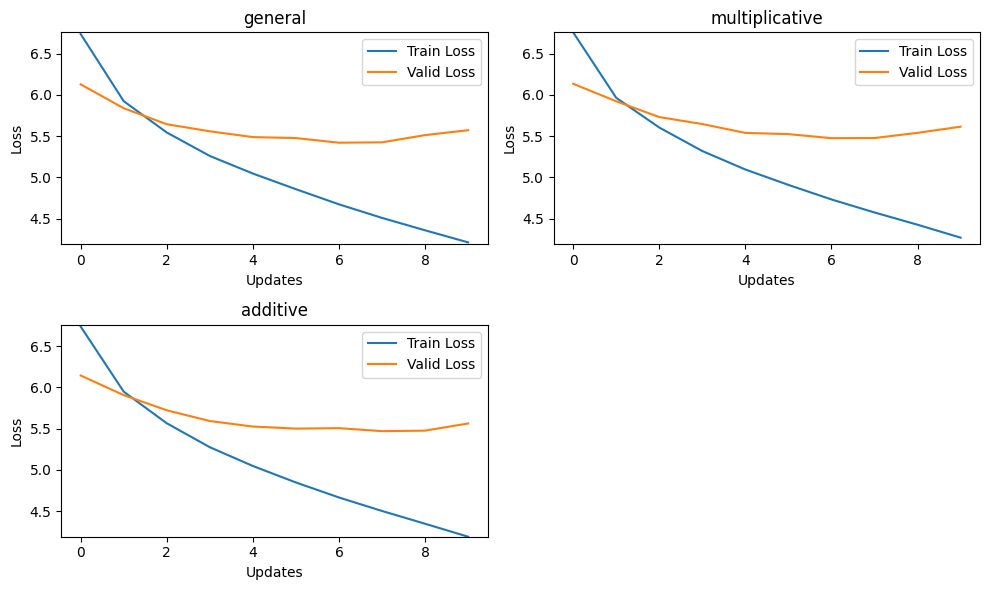

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Compute global min and max loss values
all_losses = np.concatenate([
    np.array(model_losses[model][loss_type])
    for model in model_losses
    for loss_type in ['train loss', 'valid loss']
])
y_lower_lim, y_upper_lim = all_losses.min(), all_losses.max()

# Determine subplot grid size dynamically
num_models = len(model_losses)
rows = (num_models + 1) // 2  # Ensure enough rows for all models
fig, axs = plt.subplots(rows, 2, figsize=(10, 6))
axs = axs.flatten()  # Flatten to handle any number of models

for i, (model_name, losses) in enumerate(model_losses.items()):
    ax = axs[i]
    ax.plot(losses['train loss'], label='Train Loss')
    ax.plot(losses['valid loss'], label='Valid Loss')
    ax.legend()
    ax.set_xlabel('Updates')
    ax.set_ylabel('Loss')
    ax.set_title(model_name)
    ax.set_ylim(y_lower_lim, y_upper_lim)

# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()


In [63]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 25, 18612])

In [64]:
output = output.squeeze(0)

In [65]:
output.shape

torch.Size([25, 18612])

In [66]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([24, 18612])

In [67]:
output_max = output.argmax(1) #returns max indices

In [68]:
output_max

tensor([ 79,   0,   0,   0,   0,   4,   3,   0,   0,  26,  22,  14,  22,  22,
         31,   4,   3,   7,   0, 212,  22,   4,   3,   0], device='mps:0')

In [69]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [70]:
for token in output_max:
    print(mapping[token.item()])

इस्राएलका
<unk>
<unk>
<unk>
<unk>
।
<eos>
<unk>
<unk>
भयो
थियो
पनि
थियो
थियो
गरे
।
<eos>
र
<unk>
जना
थियो
।
<eos>
<unk>


In [71]:
attentions.shape

torch.Size([1, 8, 25, 30])

In [72]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([25, 30])

In [73]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'It',
 'happened',
 'after',
 'the',
 'death',
 'of',
 'Saul',
 ',',
 'when',
 'David',
 'was',
 'returned',
 'from',
 'the',
 'slaughter',
 'of',
 'the',
 'Amalekites',
 ',',
 'and',
 'David',
 'had',
 'stayed',
 'two',
 'days',
 'in',
 'Ziklag',
 ';',
 '<eos>']

In [74]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'इस्राएलका',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '।',
 '<eos>',
 '<unk>',
 '<unk>',
 'भयो',
 'थियो',
 'पनि',
 'थियो',
 'थियो',
 'गरे',
 '।',
 '<eos>',
 'र',
 '<unk>',
 'जना',
 'थियो',
 '।',
 '<eos>',
 '<unk>']

===== Generating Attention Map for general Model =====


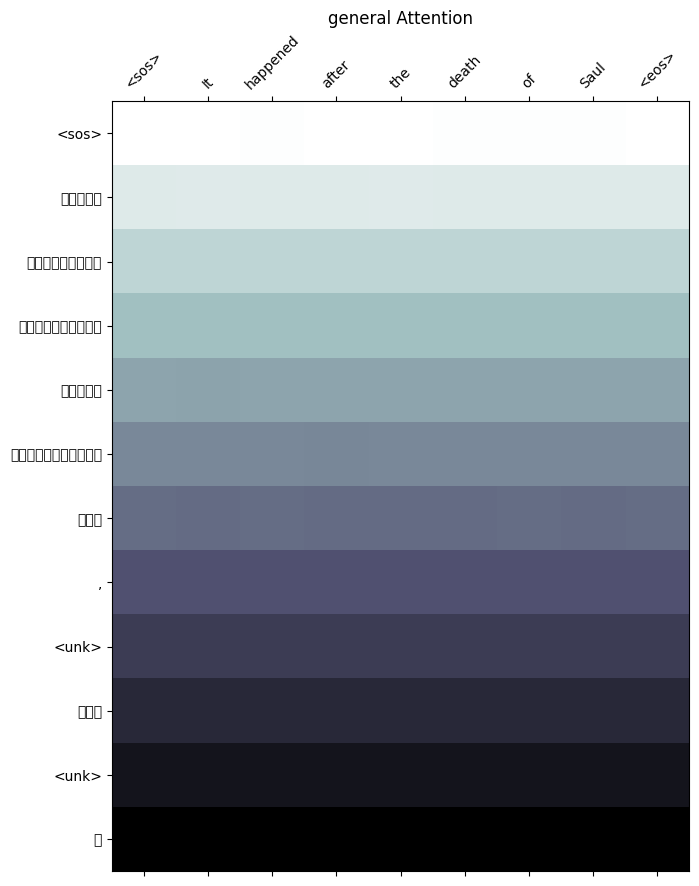

===== Generating Attention Map for multiplicative Model =====


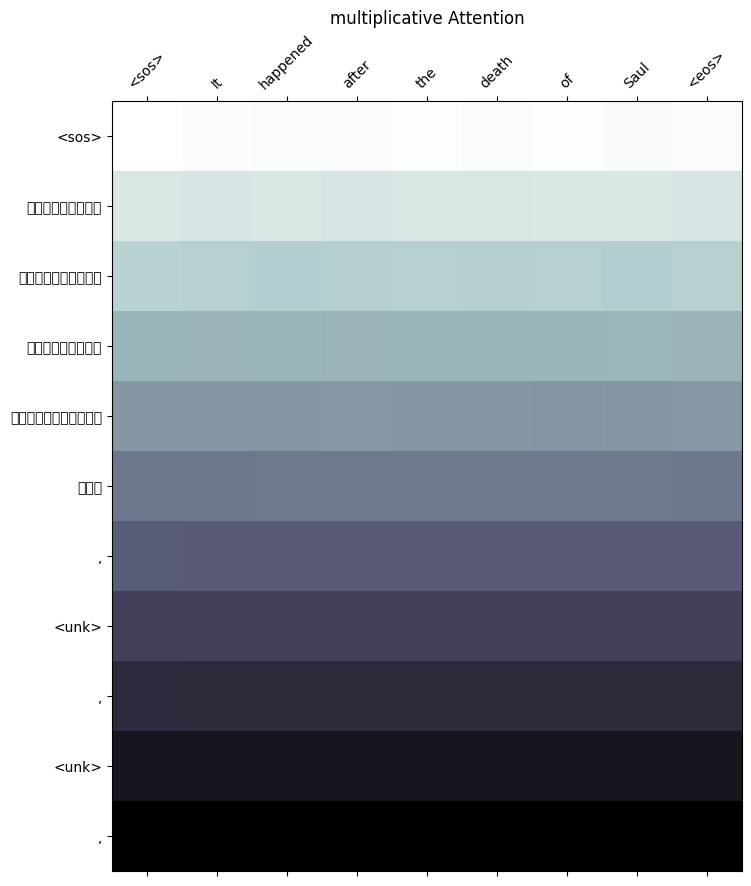

===== Generating Attention Map for additive Model =====


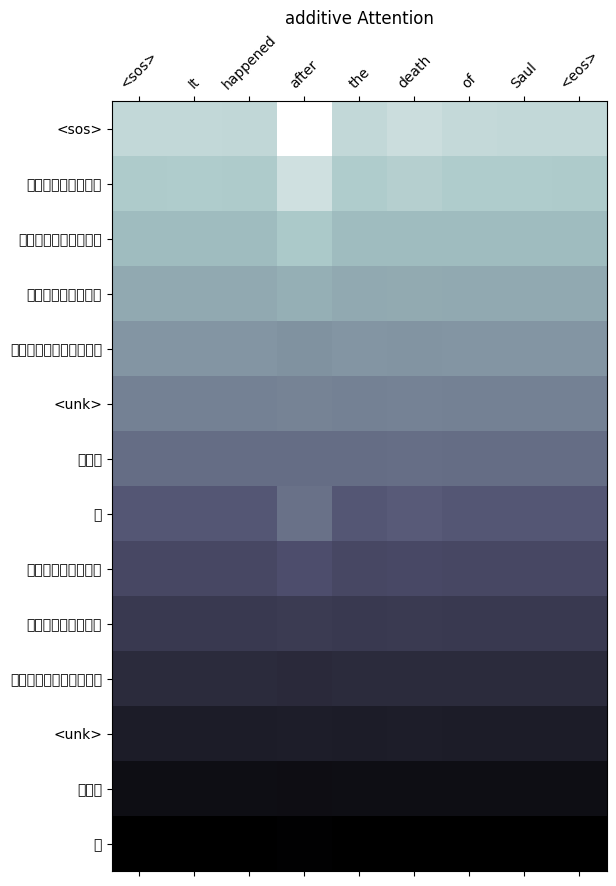

In [75]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gc

# Define a function to visualize attention maps
def display_attention(sentence, translation, attention, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # Squeeze attention tensor to remove batch dimension
    attention = attention.squeeze(0)  # Remove the batch dimension (1, ...)
    
    # Average over all attention heads (if there are multiple heads)
    if attention.ndim == 3:  # (num_heads, src_len, trg_len)
        attention = attention.mean(dim=0)  # Take the mean across attention heads

    # Now attention is 2D: [src_len, trg_len]
    attention = attention.cpu().detach().numpy()  # Convert to numpy for visualization

    # Plot attention map
    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks = [''] + translation  # Add translation as y-ticks
    x_ticks = [''] + sentence     # Add source sentence as x-ticks

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.title(title)
    plt.show()

# Function to generate translation and attention for each token step
def generate_translation_and_attention(model, src_tensor, src_vocab, trg_vocab, device, max_len=50):
    model.eval()
    trg_tokens = ['<sos>']
    
    attentions = []  # List to store the attention maps
    
    with torch.no_grad():
        src_mask = model.make_src_mask(src_tensor)
        enc_src = model.encoder(src_tensor, src_mask)
        
        for _ in range(max_len):
            trg_indexes = [trg_vocab[token] for token in trg_tokens]  # Convert tokens to indices
            trg_tensor = torch.tensor(trg_indexes, dtype=torch.long, device=device).unsqueeze(0)

            trg_mask = model.make_trg_mask(trg_tensor)
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

            pred_token = output.argmax(2)[:, -1].item()  # Get predicted token index
            trg_tokens.append(trg_vocab.get_itos()[pred_token])

            attentions.append(attention.cpu())  # Store the raw attention tensor

            if trg_tokens[-1] == '<eos>':
                break

    # Normalize attention tensor shapes
    max_attention_length = max([attn.shape[2] for attn in attentions])  # Find the maximum attention length along the sequence
    padded_attentions = []

    for attn in attentions:
        # Handle cases where attention tensor might have 4 dimensions
        if attn.dim() == 4:
            # Padding attention tensor if needed (for 4D case)
            padding_length = max_attention_length - attn.shape[2]
            if padding_length > 0:
                padded_attention = torch.cat([attn, torch.zeros((attn.shape[0], attn.shape[1], padding_length, attn.shape[3]), device=attn.device)], dim=2)
                padded_attentions.append(padded_attention)
            else:
                padded_attentions.append(attn)
        elif attn.dim() == 3:
            # Handle 3D case, padding to match max length
            padding_length = max_attention_length - attn.shape[1]
            if padding_length > 0:
                padded_attention = torch.cat([attn, torch.zeros((attn.shape[0], padding_length, attn.shape[2]), device=attn.device)], dim=1)
                padded_attentions.append(padded_attention)
            else:
                padded_attentions.append(attn)

    # Stack the padded attention tensors along the sequence dimension
    attentions = torch.cat(padded_attentions, dim=1)

    # Return the final translation tokens and the attention
    return trg_tokens, attentions

# Function to load model and visualize attention for a given type of attention mechanism
def load_model_and_visualize(model_type, test_sentence, src_vocab, trg_vocab, device):
    print(f"===== Generating Attention Map for {model_type} Model =====")

    # Load the corresponding model checkpoint
    model_path = f'app/pickle/{model_type}_Seq2SeqTransformer.pt'
    checkpoint = torch.load(model_path, map_location=device)
    params = checkpoint['hyperparameters']

    # Initialize Encoder & Decoder
    enc = Encoder(**params, device=device).to(device)
    dec = Decoder(**params, device=device).to(device)

    # Load model weights
    enc.load_state_dict(checkpoint['encoder'])
    dec.load_state_dict(checkpoint['decoder'])

    # Initialize Seq2Seq Transformer
    model = Seq2SeqTransformer(**params, encoder=enc, decoder=dec, device=device).to(device)
    model.load_state_dict(checkpoint['model'])
    model.eval()

    # Tokenize and convert input sentence into tensor
    src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](test_sentence) + ['<eos>']
    src_indexes = [src_vocab[token] for token in src_tokens]
    src_tensor = torch.tensor(src_indexes, dtype=torch.long, device=device).unsqueeze(0)  # Add batch dimension

    # Perform inference
    trg_tokens, attention = generate_translation_and_attention(model, src_tensor, src_vocab, trg_vocab, device)

    # Display attention map
    display_attention(src_tokens, trg_tokens, attention, f"{model_type} Attention")

    # Clear memory
    del model, enc, dec
    torch.mps.empty_cache()
    gc.collect()

# Example usage for testing different models
test_sentence = "It happened after the death of Saul"
for model_type in ['general', 'multiplicative', 'additive']:
    load_model_and_visualize(model_type, test_sentence, vocab_transform[SRC_LANGUAGE], vocab_transform[TRG_LANGUAGE], device)


# **Task 4. Machine Translation - Web Application Development**
Develop a simple web application
that showcases the capabilities of your language model in machine translation. (2 points)
1) The application should feature an input box where users can enter a sentence or phrase in a source
language.
2) Based on the input, the model should generate and display the translated version in a target lan-
guage. For example, if the input is ”Hello, how are you?” in English, the model might generate
”Hola, ¿c ́omo est ́as?” in Spanish.
3) Provide documentation on how the web application interfaces with the language model for machine
translation.
Note : Choose the most effective attention mechanism based on your experiments in Task 2.
As always, the example Dash Project in the GitHub repository contains an example that you can follow
(if you use the Dash framework).

### Web application can be accessed locally:  
To deploy application first download repo from github (https://github.com/sachinmalego/NLP-A3-MakeYourOwnMachineTransationLangiuage.git).   
Open in VSCode and open terminal.  
In the terminal type "python3 app.py". My local deployment address was "http://127.0.0.1:5000/" however your's might be different.  
Go to browser and enter your local deployment server address to test the application. 

According to the experiment in Task 2 Additive Attention seems to be the best mechanism overall, as it has the lowest values in both Training Loss/PPL and Validation Loss/PPL. This suggests it performs best during training and generalizes the best to unseen data.

Video of Working application: 
https://drive.google.com/file/d/170_mqczAf31MG_R_aq7ojeS2yBLLRA93/view?usp=sharing 


Screen shots of the working application is attached here with:

<img src='screenshots/Screenshot 2568-02-02 at 10.01.42 PM.png' width=800>

<img src='screenshots/Screenshot 2568-02-02 at 10.01.54 PM.png' width=800>

<img src='screenshots/Screenshot 2568-02-02 at 10.04.07 PM.png' width=800>
